# PySpark Lyft Bike Analysis (Local Demonstration)

In [1]:
#!wget https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar

In [2]:
#import packages

import pandas as pd
from pathlib import Path
import os
from pyspark.sql import SparkSession
import pyspark.sql.functions as fn
from pyspark.sql.types import DoubleType


## Load in the pre and during COVID datasets (August 2019 & 2020)

In [3]:
#spark = SparkSession.builder.master('local[4]').appName('bike').getOrCreate()

In [4]:
#IMPORTANT: If running on the cluster, change 'local[4]' to 'yarn' 

from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[4]') \
                    .config("spark.executor.memory", "1g") \
                    .config("spark.driver.memory", "1g") \
                    .config("spark.jars", "graphframes-0.8.2-spark3.2-s_2.12.jar") \
                    .config("spark.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12") \
                    .appName('bike_graphframe').getOrCreate()

In [5]:
sc = spark.sparkContext
sc.getConf().getAll()
sc.addPyFile('graphframes-0.8.2-spark3.2-s_2.12.jar')
#on cluster you can get it by
#sc.addPyFile('s3://msbx5420-spr22/graphframes-0.8.2-spark3.2-s_2.12.jar')
from graphframes import *

In [6]:
pre = spark.read.options(inferSchema = True).csv('201908-baywheels-tripdata.csv', header = True)
pre.printSchema()

root
 |-- duration_sec: integer (nullable = true)
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- start_station_id: integer (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- end_station_id: integer (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: double (nullable = true)
 |-- end_station_longitude: double (nullable = true)
 |-- bike_id: integer (nullable = true)
 |-- user_type: string (nullable = true)
 |-- bike_share_for_all_trip: string (nullable = true)



In [49]:
#Load in the during-COVID dataset. Called 'post'.

post = spark.read.options(inferSchema = True).csv('202008-baywheels-tripdata.csv', header = True)
post.printSchema()

#notice the start and end times are strings...

root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: string (nullable = true)
 |-- ended_at: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)



## Exploratory Analysis

Some data cleaning/processing will be needed to make the two datasets comparable

In [8]:
#just taking a look in ol' familiar pandas

pre.toPandas().head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip
0,68145,2019-08-31 21:27:42.2530,2019-09-01 16:23:27.4920,249,Russell St at College Ave,37.858473,-122.253253,247,Fulton St at Bancroft Way,37.867789,-122.265896,3112,Customer,No
1,53216,2019-08-31 22:34:17.5120,2019-09-01 13:21:13.9310,368,Myrtle St at Polk St,37.785434,-122.419622,78,Folsom St at 9th St,37.773717,-122.411647,2440,Customer,No
2,53182,2019-08-31 22:34:49.9420,2019-09-01 13:21:12.4570,368,Myrtle St at Polk St,37.785434,-122.419622,78,Folsom St at 9th St,37.773717,-122.411647,9743,Customer,No
3,75682,2019-08-31 14:22:02.2780,2019-09-01 11:23:24.5110,104,4th St at 16th St,37.767045,-122.390833,126,Esprit Park,37.761634,-122.390648,11418,Subscriber,No
4,30849,2019-08-31 18:47:08.0570,2019-09-01 03:21:17.6970,327,5th St at San Salvador St,37.332039,-121.881766,327,5th St at San Salvador St,37.332039,-121.881766,1553,Customer,No


In [9]:
pre.describe('duration_sec', 'user_type').show()

+-------+------------------+----------+
|summary|      duration_sec| user_type|
+-------+------------------+----------+
|  count|            210563|    210563|
|   mean| 833.5147200600295|      null|
| stddev|1928.2237799316945|      null|
|    min|                61|  Customer|
|    max|             85492|Subscriber|
+-------+------------------+----------+



In [10]:
#our post covid dataset doesnt have a duration column...yet

post.describe('member_casual').show()

+-------+-------------+
|summary|member_casual|
+-------+-------------+
|  count|       152690|
|   mean|         null|
| stddev|         null|
|    min|       casual|
|    max|       member|
+-------+-------------+



In [11]:
#lets change duration_sec to duration_min for the pre set

# define the function itself
def sec_to_min(seconds):
    return seconds/60


# convert it to a UDF
min_converter_udf = fn.udf(sec_to_min, DoubleType())

In [12]:
pre = pre.withColumn('duration_min', min_converter_udf(fn.col('duration_sec')))
pre.limit(10).toPandas().head(10)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip,duration_min
0,68145,2019-08-31 21:27:42.2530,2019-09-01 16:23:27.4920,249,Russell St at College Ave,37.858473,-122.253253,247,Fulton St at Bancroft Way,37.867789,-122.265896,3112,Customer,No,1135.750000
1,53216,2019-08-31 22:34:17.5120,2019-09-01 13:21:13.9310,368,Myrtle St at Polk St,37.785434,-122.419622,78,Folsom St at 9th St,37.773717,-122.411647,2440,Customer,No,886.933333
2,53182,2019-08-31 22:34:49.9420,2019-09-01 13:21:12.4570,368,Myrtle St at Polk St,37.785434,-122.419622,78,Folsom St at 9th St,37.773717,-122.411647,9743,Customer,No,886.366667
3,75682,2019-08-31 14:22:02.2780,2019-09-01 11:23:24.5110,104,4th St at 16th St,37.767045,-122.390833,126,Esprit Park,37.761634,-122.390648,11418,Subscriber,No,1261.366667
4,30849,2019-08-31 18:47:08.0570,2019-09-01 03:21:17.6970,327,5th St at San Salvador St,37.332039,-121.881766,327,5th St at San Salvador St,37.332039,-121.881766,1553,Customer,No,514.150000
5,17193,2019-08-31 20:52:40.7440,2019-09-01 01:39:14.5920,49,S Park St at 3rd St,37.780760,-122.394989,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,3503,Customer,No,286.550000
6,8959,2019-08-31 22:44:38.2130,2019-09-01 01:13:57.2480,323,Broadway at Kearny,37.798014,-122.405950,8,The Embarcadero at Vallejo St,37.799953,-122.398525,3028,Customer,No,149.316667
7,9528,2019-08-31 22:04:15.4460,2019-09-01 00:43:03.8740,160,West Oakland BART Station,37.805318,-122.294837,237,Fruitvale BART Station,37.775232,-122.224498,1577,Customer,No,158.800000
8,9542,2019-08-31 22:03:56.5060,2019-09-01 00:42:59.3280,160,West Oakland BART Station,37.805318,-122.294837,237,Fruitvale BART Station,37.775232,-122.224498,2534,Customer,No,159.033333
9,4121,2019-08-31 23:26:05.7510,2019-09-01 00:34:46.8930,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,4,Cyril Magnin St at Ellis St,37.785881,-122.408915,9651,Customer,No,68.683333


In [13]:
#Changing start and end times to datetime for post set
#Then we can calculate the duration of each ride


post = post.withColumn("started_at", post['started_at'].cast('Timestamp')).withColumn("ended_at", post['ended_at'].cast('Timestamp'))\
            .withColumn('duration_min', (fn.unix_timestamp("ended_at") - fn.unix_timestamp("started_at"))/60)
post = post.withColumn('duration_min', fn.col('duration_min').cast('float'))


#Check that we have 'started_at' and 'ended_at' as timestamps. Also that 'duration_min'is a float.
post.printSchema()

root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)
 |-- duration_min: float (nullable = true)



In [14]:
#Finally!

post.limit(10).toPandas().head(10)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration_min
0,2D95D2E43D0C661A,electric_bike,2020-08-03 17:16:07,2020-08-03 17:25:16,None,None,None,None,37.79,-122.43,37.78,-122.42,casual,9.150000
1,D93E9526EA37D3E4,electric_bike,2020-08-04 15:05:47,2020-08-04 15:21:46,None,None,None,None,37.80,-122.39,37.78,-122.39,casual,15.983334
2,1163F079F3B55341,electric_bike,2020-08-03 21:05:53,2020-08-03 21:12:35,None,None,None,None,37.78,-122.42,37.79,-122.42,casual,6.700000
3,DA991002C47FEB8C,electric_bike,2020-08-04 15:14:36,2020-08-04 16:21:06,None,None,None,None,37.74,-122.48,37.75,-122.47,casual,66.500000
4,8058FE5E7B4E393D,electric_bike,2020-08-02 01:00:25,2020-08-02 01:08:53,None,None,None,None,37.79,-122.41,37.77,-122.42,casual,8.466666
5,6E6FA22C800AFF8B,electric_bike,2020-08-02 13:10:03,2020-08-02 13:20:40,None,None,None,None,37.77,-122.45,37.77,-122.48,casual,10.616667
6,A483A0EF189293D7,electric_bike,2020-08-02 01:11:20,2020-08-02 01:28:39,None,None,None,None,37.79,-122.39,37.76,-122.43,casual,17.316668
7,362C5FA80F898D50,electric_bike,2020-08-01 17:34:58,2020-08-01 17:35:54,None,None,None,None,37.81,-122.44,37.81,-122.44,casual,0.933333
8,F01432990A7DD356,electric_bike,2020-08-02 14:30:34,2020-08-02 14:56:02,None,None,None,None,37.77,-122.46,37.76,-122.51,casual,25.466667
9,3852AED730ECDAFE,electric_bike,2020-08-02 16:00:18,2020-08-02 16:40:44,None,None,None,None,37.76,-122.51,37.77,-122.47,casual,40.433334


In [44]:
#Create a function to calculate pricing. ALl pricing plan information pulled from https://www.lyft.com/bikes/bay-wheels/pricing. 
#We dont have user-level data so monthly payments for subscribers is excluded from our analysis.
#This function takes into account whether the user is a subscriber or not and the duration the bike is out for.

def price(minutes, user_type):
    '''
    Pass this function duration of a ride and the user_type and it returns the price.
    Duration must be in minutes. If the user isn't subscribed, pass the function
    'Customer'. If the user is a subscriber pass any string.
    '''
    unlock_fee = 3.49
    included_time_customer = 30
    included_time_sub = 45
    price_per_min_customer = 0.30
    price_per_min_sub = 0.20
    if user_type == 'Customer':
        if minutes > included_time_customer:
            return round(unlock_fee + abs(abs(minutes - included_time_customer) * price_per_min_customer),2)
        else:
            return unlock_fee
    else:
        if minutes > included_time_sub:
            return round(abs(abs(minutes - included_time_sub) * price_per_min_sub),2)
        else:
            return 0

        
#Test the function with a subscriber's 31 minute ride.        
price(31, 'sub')

0

In [20]:
price_udf = fn.udf(price, DoubleType())

In [21]:
pre = pre.withColumn('earnings', price_udf(fn.col('duration_min'), fn.col('user_type')))
pre = pre.drop("non_user_earnings", "user_earnings")

pre.limit(10).toPandas().head(10)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip,duration_min,earnings
0,68145,2019-08-31 21:27:42.2530,2019-09-01 16:23:27.4920,249,Russell St at College Ave,37.858473,-122.253253,247,Fulton St at Bancroft Way,37.867789,-122.265896,3112,Customer,No,1135.750000,335.21
1,53216,2019-08-31 22:34:17.5120,2019-09-01 13:21:13.9310,368,Myrtle St at Polk St,37.785434,-122.419622,78,Folsom St at 9th St,37.773717,-122.411647,2440,Customer,No,886.933333,260.57
2,53182,2019-08-31 22:34:49.9420,2019-09-01 13:21:12.4570,368,Myrtle St at Polk St,37.785434,-122.419622,78,Folsom St at 9th St,37.773717,-122.411647,9743,Customer,No,886.366667,260.40
3,75682,2019-08-31 14:22:02.2780,2019-09-01 11:23:24.5110,104,4th St at 16th St,37.767045,-122.390833,126,Esprit Park,37.761634,-122.390648,11418,Subscriber,No,1261.366667,243.27
4,30849,2019-08-31 18:47:08.0570,2019-09-01 03:21:17.6970,327,5th St at San Salvador St,37.332039,-121.881766,327,5th St at San Salvador St,37.332039,-121.881766,1553,Customer,No,514.150000,148.73
5,17193,2019-08-31 20:52:40.7440,2019-09-01 01:39:14.5920,49,S Park St at 3rd St,37.780760,-122.394989,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,3503,Customer,No,286.550000,80.45
6,8959,2019-08-31 22:44:38.2130,2019-09-01 01:13:57.2480,323,Broadway at Kearny,37.798014,-122.405950,8,The Embarcadero at Vallejo St,37.799953,-122.398525,3028,Customer,No,149.316667,39.28
7,9528,2019-08-31 22:04:15.4460,2019-09-01 00:43:03.8740,160,West Oakland BART Station,37.805318,-122.294837,237,Fruitvale BART Station,37.775232,-122.224498,1577,Customer,No,158.800000,42.13
8,9542,2019-08-31 22:03:56.5060,2019-09-01 00:42:59.3280,160,West Oakland BART Station,37.805318,-122.294837,237,Fruitvale BART Station,37.775232,-122.224498,2534,Customer,No,159.033333,42.20
9,4121,2019-08-31 23:26:05.7510,2019-09-01 00:34:46.8930,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,4,Cyril Magnin St at Ellis St,37.785881,-122.408915,9651,Customer,No,68.683333,15.10


In [22]:
pre.describe('duration_min').show()

+-------+------------------+
|summary|      duration_min|
+-------+------------------+
|  count|            210563|
|   mean|13.891912001000502|
| stddev| 32.13706299886171|
|    min|1.0166666666666666|
|    max|1424.8666666666666|
+-------+------------------+



In [23]:
post.describe('duration_min').show()

+-------+------------------+
|summary|      duration_min|
+-------+------------------+
|  count|            152690|
|   mean| 35.98180053721904|
| stddev|1033.3865473391027|
|    min|        -5.7833333|
|    max|         169391.81|
+-------+------------------+



In [24]:
pre.groupBy('bike_share_for_all_trip').count().orderBy('count').show()

+-----------------------+------+
|bike_share_for_all_trip| count|
+-----------------------+------+
|                    Yes| 14136|
|                     No|196427|
+-----------------------+------+



In [25]:
post.orderBy(fn.desc('duration_min')).toPandas().head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration_min
0,593245B170A3CA61,docked_bike,2020-08-05 00:37:30,2020-11-30 15:49:19,1st St at Folsom St,SF-G29-2,SF Depot-2 (Minnesota St Outbound),SF Depot-2 (Minnesota St Outbound),37.787290,-122.394380,37.754850,-122.389734,casual,169391.812500
1,4E46D63B9026E245,docked_bike,2020-08-15 14:53:10,2020-11-09 10:02:14,Golden Gate Ave at Polk St,SF-I23-1,San Jose Depot,San Jose Depot,37.781346,-122.418409,37.344018,-121.915063,casual,123549.070312
2,F0446AAEEC9F4388,docked_bike,2020-08-29 15:28:20,2020-11-21 13:48:29,San Francisco City Hall (Polk St at Grove St),SF-I23-2,Minnesota St Depot,SF Depot,37.778650,-122.418230,37.754856,-122.389734,casual,120860.148438
3,C4A7CC88584D3607,docked_bike,2020-08-02 01:43:58,2020-10-11 22:38:18,Santa Clara St at Almaden Blvd,SJ-M9-2,Columbia Ave at Bird Ave,SJ-N7,37.333988,-121.894902,37.324126,-121.899720,casual,102054.335938
4,71F1E97B071AB127,docked_bike,2020-08-02 01:43:46,2020-10-10 10:08:10,Santa Clara St at Almaden Blvd,SJ-M9-2,Minnesota St Depot,SF Depot,37.333988,-121.894902,37.754856,-122.389734,casual,99864.398438


In [26]:
post.groupBy('rideable_type').count().orderBy('count').show()

+-------------+------+
|rideable_type| count|
+-------------+------+
|  docked_bike| 48276|
|electric_bike|104414|
+-------------+------+



In [27]:
#post.coalesce(1).write.csv('post2.csv', header = True)

In [28]:
#pre.coalesce(1).write.csv('pre2.csv', header = True)

In [29]:
#Our pricing function can now include type of bike due to the post dataset including that feature!

def price_ebikes(minutes, user_type, bike_type):
    '''
    Pass this function duration of a ride, user_type, and the type of bike and it returns the price.
    Duration must be in minutes. If the user isn't subscribed, pass the function
    'Customer'. If the user is a subscriber pass any string. Same deal for 'bike_type',
    but enter 'electric_bike' if the bike is electric and any string for traditional.
    '''
    unlock_fee = 3.49
    included_time_customer = 30
    included_time_sub = 45
    price_per_min_customer = 0.30
    price_per_min_sub = 0.20
    if bike_type == 'electric_bike':
        if user_type == 'casual':
                return round(unlock_fee + (minutes * price_per_min_customer),2)
        else:
            return (minutes * price_per_min_sub)
    else:
        if user_type == 'casual':
            if minutes > included_time_customer:
                return round(unlock_fee + ((minutes - included_time_customer) * price_per_min_customer),2)
            else:
                return unlock_fee
        else:
            if minutes > included_time_sub:
                return round(((minutes - included_time_sub) * price_per_min_sub),2)
            else:
                return 0

#Test function with a casual user on a traditional bike who rode for 31 minutes.
price_ebikes(31, 'casual', 'traditional_bike')

3.79

In [30]:
price_ebikes_udf = fn.udf(price_ebikes, DoubleType())

In [31]:
post = post.withColumn('earnings', price_ebikes_udf(fn.col('duration_min'), fn.col('member_casual'), fn.col('rideable_type')))
post.limit(10).toPandas().head(10)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration_min,earnings
0,2D95D2E43D0C661A,electric_bike,2020-08-03 17:16:07,2020-08-03 17:25:16,None,None,None,None,37.79,-122.43,37.78,-122.42,casual,9.150000,6.23
1,D93E9526EA37D3E4,electric_bike,2020-08-04 15:05:47,2020-08-04 15:21:46,None,None,None,None,37.80,-122.39,37.78,-122.39,casual,15.983334,8.29
2,1163F079F3B55341,electric_bike,2020-08-03 21:05:53,2020-08-03 21:12:35,None,None,None,None,37.78,-122.42,37.79,-122.42,casual,6.700000,5.50
3,DA991002C47FEB8C,electric_bike,2020-08-04 15:14:36,2020-08-04 16:21:06,None,None,None,None,37.74,-122.48,37.75,-122.47,casual,66.500000,23.44
4,8058FE5E7B4E393D,electric_bike,2020-08-02 01:00:25,2020-08-02 01:08:53,None,None,None,None,37.79,-122.41,37.77,-122.42,casual,8.466666,6.03
5,6E6FA22C800AFF8B,electric_bike,2020-08-02 13:10:03,2020-08-02 13:20:40,None,None,None,None,37.77,-122.45,37.77,-122.48,casual,10.616667,6.68
6,A483A0EF189293D7,electric_bike,2020-08-02 01:11:20,2020-08-02 01:28:39,None,None,None,None,37.79,-122.39,37.76,-122.43,casual,17.316668,8.69
7,362C5FA80F898D50,electric_bike,2020-08-01 17:34:58,2020-08-01 17:35:54,None,None,None,None,37.81,-122.44,37.81,-122.44,casual,0.933333,3.77
8,F01432990A7DD356,electric_bike,2020-08-02 14:30:34,2020-08-02 14:56:02,None,None,None,None,37.77,-122.46,37.76,-122.51,casual,25.466667,11.13
9,3852AED730ECDAFE,electric_bike,2020-08-02 16:00:18,2020-08-02 16:40:44,None,None,None,None,37.76,-122.51,37.77,-122.47,casual,40.433334,15.62


## Graph Analysis!

In [32]:
#Vertices are stations in the dataset.

vertices = post.select(fn.col('start_station_name').alias('id')).union(pre.select(fn.col('end_station_name').alias('id'))).distinct()
vertices.show()
vertices.count()

+--------------------+
|                  id|
+--------------------+
|      San Pablo Park|
|Alemany Blvd at S...|
|24th St at Bartle...|
|19th St at Willia...|
|Delmas Ave at Vir...|
|Shattuck Ave at H...|
| Tehama St at 1st St|
|53rd St at Hollis St|
|Backesto Park (Ja...|
|Miles Ave at Cavo...|
|Spear St at Folso...|
|Washington St at ...|
|49th St at Telegr...|
|10th St at Missio...|
|McKinnon Ave at 3...|
|Jackson St at 11t...|
|Cruise Terminal a...|
|Quesada Ave at 3r...|
|48th Ave at Cabri...|
|59th St at Horton St|
+--------------------+
only showing top 20 rows



474

In [33]:
#Edges are routes between stations.

edges = post.select("start_station_name", "end_station_name", "earnings").withColumnRenamed('start_station_name', 'src').withColumnRenamed('end_station_name', 'dst').distinct().dropna()

edges.groupBy('src','dst', 'earnings').count().orderBy('count', ascending = False).show()
edges.groupBy('src','dst', 'earnings').count().orderBy('earnings', ascending = False).show()

+--------------------+--------------------+------------------+-----+
|                 src|                 dst|          earnings|count|
+--------------------+--------------------+------------------+-----+
|   18th St at Noe St|   18th St at Noe St|              3.75|    1|
|   18th St at Noe St|   18th St at Noe St|              3.51|    1|
|Bancroft Way at T...|Bancroft Way at T...|             11.14|    1|
|Beale St at Harri...|Brannan St at Col...|              4.24|    1|
|Addison St at Fou...|Addison St at Fou...|              3.73|    1|
|7th St at Brannan St|Washington St at ...|              3.49|    1|
|Dolores St at 15t...|Dolores St at 15t...|              3.75|    1|
|The Embarcadero a...|Dolores St at 15t...|             10.01|    1|
| Otis St at Brady St|Bryant St at 15th St|              6.25|    1|
|20th St at Bryant St|Dolores St at 15t...|1.2733333587646485|    1|
|The Embarcadero a...|7th Ave at Cabril...| 4.656666564941406|    1|
|7th Ave at Cabril...|7th Ave at C

In [34]:
#This query returns routes that go to different stations. Also takes into account popularity of the route,
#average earnings for the route, and lastly filters out routes with an unrealistic earnings figure.

edges_count = edges.groupBy('src','dst').agg(fn.count('src').alias('path_count'))

edge_earnings = edges.groupBy('src','dst').agg(fn.avg('earnings').alias('avg_earnings'))\
.orderBy(fn.avg('earnings'), ascending = False).filter(fn.col('avg_earnings') < 100)

edges_joined = edges_count.join(edge_earnings,['src','dst'])
edges_joined.orderBy('path_count', ascending = False).filter(~(fn.col('src') == fn.col('dst'))).show()

+--------------------+--------------------+----------+------------------+
|                 src|                 dst|path_count|      avg_earnings|
+--------------------+--------------------+----------+------------------+
|   4th St at 16th St|  Berry St at 4th St|        44| 2.170909087007696|
|Fell St at Stanya...|48th Ave at Cabri...|        38| 24.38535088589317|
|Market St at 10th St|Powell St BART St...|        27| 6.592592590826529|
|Market St at Steu...|  Berry St at 4th St|        27|3.2258024844416866|
|Lake Merritt BART...|  Jack London Square|        26| 7.130769230769231|
|  Berry St at 4th St|   4th St at 16th St|        26| 6.011025641147906|
|Powell St BART St...|Market St at 10th St|        26| 4.813974380493164|
|Powell St at Colu...|Buchanan St at No...|        25| 7.443199999999999|
|23rd St at Tennes...|  Berry St at 4th St|        25|  2.10146665725708|
|Broderick St at O...|Fell St at Stanya...|        25| 6.304000003814698|
|Market St at Dolo...|Market St at 10t

In [36]:
edge_earnings = edges.groupBy('src','dst').agg(fn.avg('earnings').alias('avg_earnings'))\
.orderBy(fn.avg('earnings'), ascending = False).filter(fn.col('avg_earnings') < 100)

In [37]:
#Make the graph

bike_graph = GraphFrame(vertices, edges)
print(bike_graph)

GraphFrame(v:[id: string], e:[src: string, dst: string ... 1 more field])


In [38]:
#Take a look and inDegree and outDegree

bike_graph.inDegrees.sort(fn.desc("inDegree")).show()
bike_graph.outDegrees.sort(fn.desc("outDegree")).show()

+--------------------+--------+
|                  id|inDegree|
+--------------------+--------+
|Fell St at Stanya...|     718|
|Market St at 10th St|     706|
|Mission Dolores Park|     614|
|  Hyde St at Post St|     558|
|Powell St BART St...|     556|
|48th Ave at Cabri...|     524|
|Buchanan St at No...|     519|
|Market St at Dolo...|     510|
|   4th St at 16th St|     495|
|Sanchez St at 15t...|     488|
|17th St at Valenc...|     484|
|Frederick St at A...|     467|
|Bay St at Fillmor...|     461|
|Laguna St at Haye...|     457|
|  Mission Playground|     456|
|Powell St at Colu...|     443|
|Lombard St at Col...|     434|
| Jones St at Post St|     433|
|Market St at Steu...|     429|
|4th St at Mission...|     427|
+--------------------+--------+
only showing top 20 rows

+--------------------+---------+
|                  id|outDegree|
+--------------------+---------+
|Market St at 10th St|      732|
|Fell St at Stanya...|      683|
|Mission Dolores Park|      627|
|  Hyde 

In [39]:
#PageRank to determine most important stations.

pageranks = bike_graph.pageRank(resetProbability = 0.15, maxIter = 5)
pageranks.vertices.orderBy(pageranks.vertices.pagerank.desc()).show()

+--------------------+------------------+
|                  id|          pagerank|
+--------------------+------------------+
|Grand Ave at Perk...|3.5093949098935555|
|5th St at Virgini...|3.3483187868394193|
|Market St at 10th St| 3.307337621632273|
|Fell St at Stanya...| 3.231828079256804|
|Lakeside Dr at 14...| 3.013898076516019|
|Mission Dolores Park| 2.972910958213613|
|  Jack London Square| 2.768271032860654|
|Julian St at The ...|2.7307847357490274|
|Buchanan St at No...|2.6843398654141084|
|Powell St BART St...|2.6799124562871115|
|  Hyde St at Post St| 2.633613207136681|
|48th Ave at Cabri...|2.6104033929419117|
|     Bestor Art Park|2.5911337475696476|
|Addison St at Fou...|2.5671900833596357|
|Grand Ave at Sant...|  2.53747959358033|
|   4th St at 16th St|2.4432867216556806|
|Bay St at Fillmor...| 2.402992561335341|
|Market St at Dolo...|2.3949365352046654|
|Sanchez St at 15t...|2.3736382947037304|
|17th St at Valenc...|2.3653423201731467|
+--------------------+------------

In [40]:
#Clustering the stations is also possible!

clusters = bike_graph.labelPropagation(maxIter=5)
clusters.orderBy(fn.asc('label')).show()
clusters.count()

+--------------------+------------+
|                  id|       label|
+--------------------+------------+
|      San Pablo Park|           1|
|19th St at Willia...| 17179869185|
|5th St at Brannan St| 17179869186|
|53rd St at Hollis St| 34359738368|
|Backesto Park (Ja...| 34359738369|
|Shattuck Ave at H...| 34359738370|
|10th St at Missio...| 60129542144|
|49th St at Telegr...| 60129542145|
|El Embarcadero at...| 68719476736|
|West Oakland BART...| 68719476739|
|Cruise Terminal a...| 85899345920|
|  Irwin St at 8th St| 85899345920|
|48th Ave at Cabri...| 94489280512|
|59th St at Horton St|103079215104|
|The Embarcadero a...|103079215105|
|21st St at Santa ...|120259084288|
|Autumn Parkway at...|120259084289|
|Grand Ave at Perk...|120259084290|
|34th St at Telegr...|128849018880|
|Milvia St at Derb...|128849018882|
+--------------------+------------+
only showing top 20 rows



473

## Graph Visualization

In [50]:
import networkx as nx

#turn the large network into a smaller one and create network from pandas
vertice = bike_graph.vertices.toPandas()
edges = bike_graph.edges.groupBy('src','dst').agg(fn.count('*').alias('trips'), fn.avg('earnings').alias('avg_earnings')).toPandas()
ranks = pageranks.vertices.toPandas()
labels = clusters.toPandas()
#connected = components.toPandas()

vertice.index = vertice['id']
ranks.index = ranks['id']
labels.index = labels['id']
#connected.index = connected['id']

ranks['pagerank'] = ranks['pagerank'] * 100
edges['trips'] = edges['trips'] / 100

graph = nx.from_pandas_edgelist(edges, 'src',  'dst', ['trips', 'avg_earnings'])
nx.set_node_attributes(graph, pd.Series(vertice.id, index=vertice.id).to_dict(), 'label')
nx.set_node_attributes(graph, pd.Series(ranks.pagerank, index=ranks.id).to_dict(), 'size')
nx.set_node_attributes(graph, pd.Series(labels.label, index=labels.id).to_dict(), 'group')
#nx.set_node_attributes(graph, pd.Series(connected.component, index=connected.id).to_dict(), 'component')

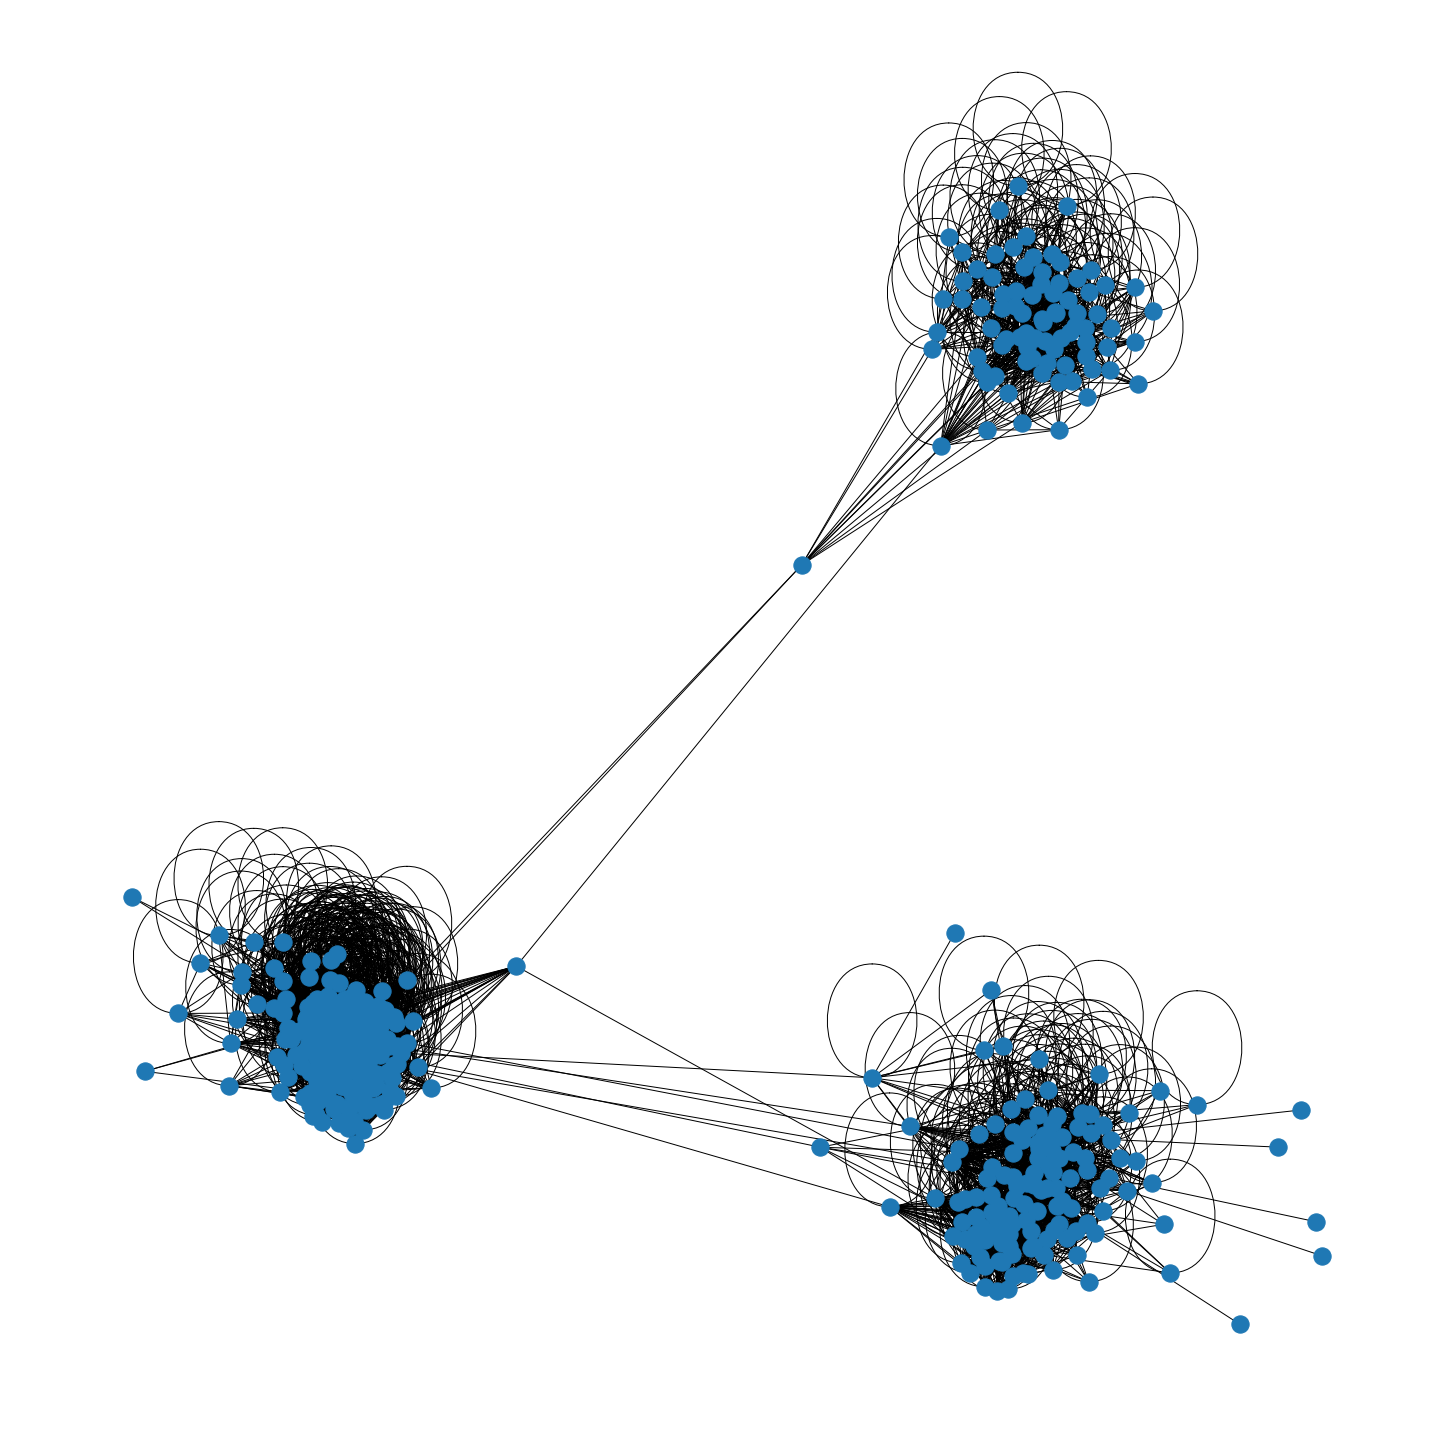

<Figure size 1440x1440 with 0 Axes>

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [20, 20]

nx.draw(graph)
plt.figure()
plt.show()

In [65]:
!pip install pyvis

In [63]:
#alternatively use pyvis to visualize interactive graph
from pyvis.network import Network

net = Network(height=1000, width=1000, notebook=True)
net.barnes_hut()
net.from_nx(graph, node_size_transf=(lambda x: x/10))
net.show('graph.html')

## Extra Analysis for Earnings of Traditional vs. Electric Bikes

In [41]:
#Filter out unrealistic trips.

post_real = post.filter(fn.col('earnings') <100)

In [42]:


post_real.groupBy('rideable_type').avg('earnings').show()

+-------------+-----------------+
|rideable_type|    avg(earnings)|
+-------------+-----------------+
|  docked_bike| 5.82823835006445|
|electric_bike|6.921712185308441|
+-------------+-----------------+



In [43]:
post_real.groupBy('member_casual').avg('duration_min').show()

+-------------+------------------+
|member_casual| avg(duration_min)|
+-------------+------------------+
|       casual| 20.73967231795407|
|       member|15.964482997433166|
+-------------+------------------+

